In [151]:
import torch, torchvision
import detectron2

from detectron2.utils.logger import setup_logger

import numpy as np
import cv2
import random
import glob
import torch
import time
import pickle
import os

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import detection_utils as utils
from detectron2.data import samplers

from torch.utils.data import Dataset, DataLoader

In [152]:
class PredictDataset(Dataset):
    
    def __init__(self, glob_string):
        self.image_files = sorted(glob.glob(glob_string))
        
    def __len__(self):
        return len(self.image_files) // 2
    
    def __getitem__(self, idx):
        image_raw = cv2.imread(self.image_files[idx * 2])
        height, width = image_raw.shape[:2]
        image = torch.as_tensor(image_raw.astype("float32").transpose(2, 0, 1)).contiguous()
        image_dict0 = {"image": image, "height": height, "width": width, "file_name": self.image_files[idx * 2]}
        
        image_raw = cv2.imread(self.image_files[idx * 2 + 1])
        height, width = image_raw.shape[:2]
        image = torch.as_tensor(image_raw.astype("float32").transpose(2, 0, 1)).contiguous()
        image_dict1 = {"image": image, "height": height, "width": width, "file_name": self.image_files[idx * 2 + 1]}
        return [image_dict0, image_dict1]

In [153]:
def cv2_imshow(im):
    cv2.imshow('file', im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [154]:
## root on my local computer
# root = 'C:/Users/cloftus/Documents/thermal_baboons/annotations/'

## root on my HiWi computer
root = 'C:/Users/meerkat/Documents/thermal_baboon/'

## root on the server
#root = 'Y:/cloftus/analysis/thermal_baboon_project/'

from detectron2.data.datasets import register_coco_instances

output_folder = root + 'DATA/short_temp/all_coco_annotations'
coco_annotation_file = os.path.join(output_folder, 'baboon_coco_annotations.json')
output_image_folder = os.path.join(output_folder, 'images')

register_coco_instances("train",  {}, coco_annotation_file, output_image_folder ) 

train_metadata = MetadataCatalog.get("train")

AssertionError: Dataset 'train' is already registered!

In [155]:
##base root on my local computer
#base_root = 'C:/Users/cloftus/'

##base root on the HiWi computer
base_root = 'C:/Users/meerkat/'

os.chdir( base_root + 'detectron2-windows/configs/COCO-Detection/' )

os.listdir()

['faster_rcnn_R_101_C4_3x.yaml',
 'faster_rcnn_R_101_DC5_3x.yaml',
 'faster_rcnn_R_101_FPN_3x.yaml',
 'faster_rcnn_R_50_C4_1x.yaml',
 'faster_rcnn_R_50_C4_3x.yaml',
 'faster_rcnn_R_50_DC5_1x.yaml',
 'faster_rcnn_R_50_DC5_3x.yaml',
 'faster_rcnn_R_50_FPN_1x.yaml',
 'faster_rcnn_R_50_FPN_3x.yaml',
 'faster_rcnn_X_101_32x8d_FPN_3x.yaml',
 'fast_rcnn_R_50_FPN_1x.yaml',
 'output',
 'retinanet_R_101_FPN_3x.yaml',
 'retinanet_R_50_FPN_1x.yaml',
 'retinanet_R_50_FPN_3x.yaml',
 'rpn_R_50_C4_1x.yaml',
 'rpn_R_50_FPN_1x.yaml']

In [156]:
os.chdir( root + 'RESULTS/' )

In [157]:
os.listdir()

['detectron_output', 'images_to_process']

In [158]:
cfg = get_cfg()
cfg.merge_from_file(
    base_root + 'detectron2-windows/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'
)

baboon_weights = root + "RESULTS/detectron_output/output/full-aug_maxiter-2000_lr-0.019_detectPerIm-200_minsize-0_batchsize-8/model_final.pth"



cfg.MODEL.WEIGHTS = (baboon_weights)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (100)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.TEST.DETECTIONS_PER_IMAGE = 100

In [159]:
cfg.MODEL.WEIGHTS

'C:/Users/meerkat/Documents/thermal_baboon/RESULTS/detectron_output/output/full-aug_maxiter-2000_lr-0.019_detectPerIm-200_minsize-0_batchsize-8/model_final.pth'

In [160]:
model = build_model(cfg)
_ = model.eval()

checkpointer = DetectionCheckpointer(model)
_ = checkpointer.load(cfg.MODEL.WEIGHTS)

In [161]:
# FOLDER THAT HAS THE IMAGES YOU WANT TO PROCESS
images_folder = root + 'DATA/images_to_process'

dataset = PredictDataset(os.path.join(images_folder, "*.tiff"))

save_root = os.path.join('.', os.path.basename(images_folder))
os.makedirs(save_root, exist_ok=True)

In [162]:
# def build_detection_test_loader(cfg, dataset_name, mapper=None):
#     """
#     Similar to `build_detection_train_loader`.
#     But this function uses the given `dataset_name` argument (instead of the names in cfg),
#     and uses batch size 1.
#     Args:
#         cfg: a detectron2 CfgNode
#         dataset_name (str): a name of the dataset that's available in the DatasetCatalog
#         mapper (callable): a callable which takes a sample (dict) from dataset
#            and returns the format to be consumed by the model.
#            By default it will be `DatasetMapper(cfg, False)`.
#     Returns:
#         DataLoader: a torch DataLoader, that loads the given detection
#         dataset, with test-time transformation and batching.
#     """
#     dataset_dicts = get_detection_dataset_dicts(
#         [dataset_name],
#         filter_empty=False,
#         proposal_files=[
#             cfg.DATASETS.PROPOSAL_FILES_TEST[list(cfg.DATASETS.TEST).index(dataset_name)]
#         ]
#         if cfg.MODEL.LOAD_PROPOSALS
#         else None,
#     )

#     dataset = DatasetFromList(dataset_dicts)
#     if mapper is None:
#         mapper = DatasetMapper(cfg, False)
#     dataset = MapDataset(dataset, mapper)

#     sampler = samplers.InferenceSampler(len(dataset))
#     # Always use 1 image per worker during inference since this is the
#     # standard when reporting inference time in papers.
#     batch_sampler = torch.utils.data.sampler.BatchSampler(sampler, 2, drop_last=False)

#     data_loader = torch.utils.data.DataLoader(
#         dataset,
#         num_workers=cfg.DATALOADER.NUM_WORKERS,
#         batch_sampler=batch_sampler,
#         collate_fn=trivial_batch_collator,
#     )
#     return data_loader


# def trivial_batch_collator(batch):
#     """
#     A batch collator that does nothing.
#     """
#     return batch

In [163]:
data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

In [164]:
cuda0 = torch.device('cuda:0')

In [165]:
list( data_loader )

[[{'image': tensor([[[[255., 255., 255.,  ..., 255., 255., 255.],
             [255., 255., 255.,  ..., 255., 255., 255.],
             [255., 255., 255.,  ..., 255., 255., 255.],
             ...,
             [255., 255., 255.,  ..., 255., 255., 255.],
             [255., 255., 255.,  ..., 255., 255., 255.],
             [255., 255., 255.,  ..., 255., 255., 255.]],
   
            [[255., 255., 255.,  ..., 255., 255., 255.],
             [255., 255., 255.,  ..., 255., 255., 255.],
             [255., 255., 255.,  ..., 255., 255., 255.],
             ...,
             [255., 255., 255.,  ..., 255., 255., 255.],
             [255., 255., 255.,  ..., 255., 255., 255.],
             [255., 255., 255.,  ..., 255., 255., 255.]],
   
            [[255., 255., 255.,  ..., 255., 255., 255.],
             [255., 255., 255.,  ..., 255., 255., 255.],
             [255., 255., 255.,  ..., 255., 255., 255.],
             ...,
             [255., 255., 255.,  ..., 255., 255., 255.],
             [2

### This is where the actual image inference happens

In [166]:
import pickle
import os

max_batches = 10000

t = time.time()
with torch.no_grad():
    for batch_num, image_batch in enumerate(data_loader):
        if batch_num >= max_batches:
            break
            
        if batch_num % 250 == 0:
            print('{} images processed'.format(batch_num * 2))
        for i in range(len(image_batch)):
            image_batch[i]['image'] = np.squeeze(image_batch[i]['image'])

            image_batch[i]['image'] = image_batch[i]['image'].to(cuda0)
            image_batch[i]['width'] = image_batch[i]['width'].to(cuda0).item()
            image_batch[i]['height'] = image_batch[i]['height'].to(cuda0).item()
            #print(image_batch['image'].shape)
            #print(image_batch)
        predictions = model(image_batch)
        for preds, im_dict in zip(predictions, image_batch):
            name = os.path.splitext(os.path.basename(im_dict['file_name'][0]))[0]
            file = os.path.join(save_root, '{}-predictions.pkl'.format(name))
            preds_instance = preds["instances"].to("cpu")
            with open(file, 'wb') as out:
                pickle.dump(preds_instance, out)
                out.close()
            
print(time.time() - t)

0 images processed
2.339280366897583


In [167]:
os.path.join(images_folder, "*.tiff")

'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\*.tiff'

### Below is some stuff to dig into the output

In [168]:
type(predictions[0]['instances'])

detectron2.structures.instances.Instances

In [169]:
import os
name = image_batch[0]['file_name'][0].split('/')[-2]

In [170]:
image_batch[0]['file_name'][0].split('/')

['C:',
 'Users',
 'meerkat',
 'Documents',
 'thermal_baboon',
 'DATA',
 'images_to_process\\015_20190731_153859000000.tiff']

In [171]:
name

'DATA'

In [172]:
# file = os.path.join(save_root, '{}-predictions.pkl'.format(name))
# preds = predictions[0]["instances"].to("cpu")
# with open(file, 'wb') as out:
#     pickle.dump(preds, out)
#     out.close()

In [173]:
files

['C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\011_20190731_152836800000.tiff',
 'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\012_20190731_153112400000.tiff',
 'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\013_20190731_153347800000.tiff',
 'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\014_20190731_153623400000.tiff',
 'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\015_20190731_153859000000.tiff',
 'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\016_20190731_154134600000.tiff']

In [143]:
files = sorted(glob.glob(os.path.join(save_root, '*-predictions.pkl')))

all_detections = []
raw_instances = []

for file in files[:]:
    with open(file, 'rb') as readfile:
        detections=pickle.load(readfile)
        #print( detections )
    detection_dict = detections.get_fields()
    detection_dict['pred_boxes'] = detection_dict['pred_boxes'].tensor.numpy()
    detection_dict['scores'] = detection_dict['scores'].numpy()
    detection_dict['pred_classes'] = detection_dict['pred_classes'].numpy()
    detection_dict['image_name'] = os.path.basename(file).split('-')[0]
    all_detections.append(detection_dict)
    raw_instances.append(detections)

np_detections_file = os.path.join(save_root, '{}_detections.npy'.format(name))
np.save(np_detections_file, all_detections)


In [150]:
files

['C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\011_20190731_152836800000.tiff',
 'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\012_20190731_153112400000.tiff',
 'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\013_20190731_153347800000.tiff',
 'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\014_20190731_153623400000.tiff',
 'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\015_20190731_153859000000.tiff',
 'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\016_20190731_154134600000.tiff']

In [139]:
raw_instances[0]

[Instances(num_instances=50, image_height=2159, image_width=2871, fields=[pred_boxes: [[1232.3796    1571.6405    1295.5889    1680.8558   ]
  [1164.4966    1472.8717    1224.4058    1579.4071   ]
  [1206.4468    1568.1228    1258.0178    1654.1323   ]
  [ 966.7386    1386.7134    1019.34406   1479.5493   ]
  [1147.5312    1414.6814    1209.4348    1513.2412   ]
  [1532.5107     900.55756   1605.8889    1014.53766  ]
  [1279.5741    1583.896     1335.1019    1679.3896   ]
  [ 678.3387    1503.5125     713.73663   1555.05     ]
  [1448.0385    1258.3429    1504.3253    1364.3473   ]
  [ 810.62573   1150.2181     882.48047   1289.6073   ]
  [ 936.90753   1388.1755     984.13983   1476.4624   ]
  [ 761.60223   1200.9388     813.6972    1309.985    ]
  [1788.2394    1016.2301    1856.1534    1120.2909   ]
  [1440.7096    1183.6375    1492.6532    1268.7029   ]
  [1977.3756    1928.9984    2136.857     2086.9734   ]
  [ 885.08606      4.3981705 1098.9517     157.04312  ]
  [1235.3418    181

In [182]:
os.getcwd()

'C:\\Users\\meerkat\\Documents\\thermal_baboon\\RESULTS'

['.\\images_to_process\\DATA_detections.npy']
(46,)
012_20190731_153112400000


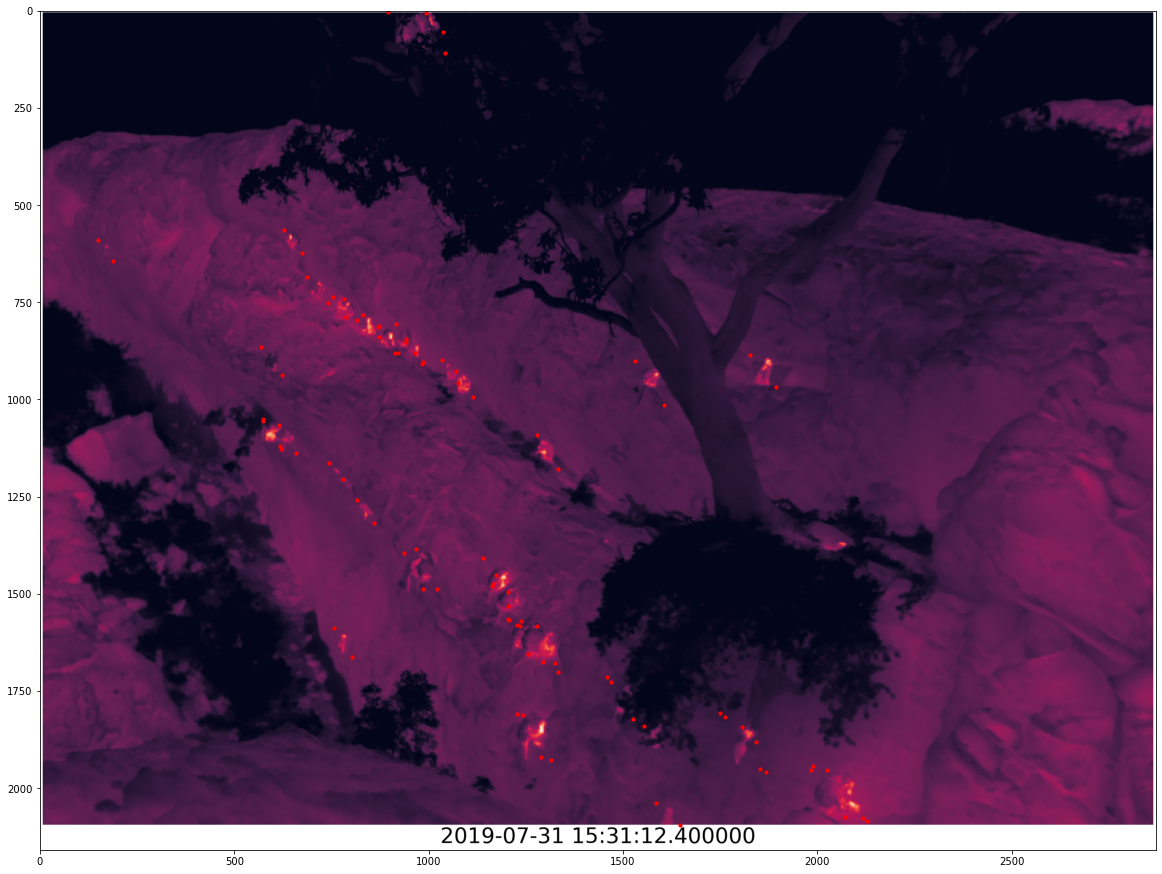

In [203]:
import numpy as np
import glob

%matplotlib inline

files = [np_detections_file]

print( files )


width = 20
    
height = 20

fig = plt.figure( figsize = ( width, height ) )  



for file in files[0:1]:
    detections = np.load(file, allow_pickle=True)
    print(detections[1]['scores'].shape)
    print(detections[1]['image_name'])
    
    img = plt.imread( root + 'DATA/images_to_process/' + detections[1]['image_name'] + '.tiff' )
    
    #img = cv2.cvtColor( img, cv2.COLOR_BGR2RGB )
    plt.imshow( img )
    
    # Get the current reference
    ax = plt.gca()

    for item in detections[1]['pred_boxes']:
        
        x1 = item[ 0 ]
        
        x2 = item[ 2 ]
        
        y1 = item[ 1 ]
        
        y2 = item[ 3 ]
        
        # Create a Rectangle patch
        rect = Rectangle( (x1, y1 ), wid, hei, linewidth=1, edgecolor='c', facecolor='none' )

        # Add the patch to the Axes
        ax.add_patch( rect )
        
        wid = x2 - x1
        
        hei = y2 - y1
        
        
        plt.scatter(x= [ item[ [ 0, 2 ] ] ], y= [ item[ [ 1, 3 ] ] ], c='r', s=10)

    
    
    
    
    plt.savefig('', bbox_inches = 'tight' )

In [201]:
item

array([1983.385 , 1952.156 , 2070.5283, 2074.9976], dtype=float32)

In [206]:
thermal_file = 'X:/baboon/archive/rawdata/video/thermal/2019_summer/cliff_data/thermal/viewpoint_1/T1020/20190806/20190806_16_20_00-__TIME__.seq'

In [ ]:
import fnv
import fnv.reduce
import fnv.file  
import numpy as np
import seaborn as sns
import datetime as dt
import time
import pandas as pd
from tkinter import filedialog
from tkinter import *
import os
import matplotlib.pyplot as plt
import glob
import h5py
import gc
import shlex
import pipes
from subprocess import check_call


im = fnv.file.ImagerFile( thermal_file )




In [197]:
for item in detections[1]['pred_boxes']:
    print(item)
    print()

[1166.4854 1473.7229 1235.4211 1581.6804]

[1236.8811 1568.8763 1294.332  1675.1002]

[1206.9285 1566.4751 1255.0422 1653.7598]

[ 966.7656 1383.4495 1020.3528 1487.5322]

[1138.6771 1408.4785 1204.4703 1531.5437]

[1278.1886 1092.2544 1332.2189 1178.9233]

[ 817.0091 1258.2281  858.8149 1318.5145]

[1242.9623 1812.0809 1315.1368 1927.1974]

[1531.4117   900.669   1606.2867  1014.42303]

[782.8597 742.1072 814.7293 794.766 ]

[916.46606 805.12994 963.8552  880.269  ]

[ 757.09106 1588.5021   801.8939  1661.8075 ]

[1280.1143 1583.5828 1326.1838 1677.6499]

[569.0882  863.9264  621.9992  937.88135]

[686.98755 685.6796  740.0679  752.1009 ]

[1070.3647  927.8551 1115.354   992.4563]

[627.9764  564.5363  673.18427 623.6451 ]

[ 616.09186 1066.1013   660.0201  1136.4827 ]

[830.6952  783.3552  871.1749  838.69885]

[150.76321 588.68286 187.30399 644.3578 ]

[1988.7675 1943.4216 2127.2007 2084.0642]

[ 895.3774       3.6609497 1042.6356     108.40675  ]

[754.0172  736.3619  787.81824 787

In [119]:
# image_files = glob.glob(images_folder + '/*.jpg')

In [121]:
detections

array([{'pred_boxes': array([[1232.3796   , 1571.6405   , 1295.5889   , 1680.8558   ],
       [1164.4966   , 1472.8717   , 1224.4058   , 1579.4071   ],
       [1206.4468   , 1568.1228   , 1258.0178   , 1654.1323   ],
       [ 966.7386   , 1386.7134   , 1019.34406  , 1479.5493   ],
       [1147.5312   , 1414.6814   , 1209.4348   , 1513.2412   ],
       [1532.5107   ,  900.55756  , 1605.8889   , 1014.53766  ],
       [1279.5741   , 1583.896    , 1335.1019   , 1679.3896   ],
       [ 678.3387   , 1503.5125   ,  713.73663  , 1555.05     ],
       [1448.0385   , 1258.3429   , 1504.3253   , 1364.3473   ],
       [ 810.62573  , 1150.2181   ,  882.48047  , 1289.6073   ],
       [ 936.90753  , 1388.1755   ,  984.13983  , 1476.4624   ],
       [ 761.60223  , 1200.9388   ,  813.6972   , 1309.985    ],
       [1788.2394   , 1016.2301   , 1856.1534   , 1120.2909   ],
       [1440.7096   , 1183.6375   , 1492.6532   , 1268.7029   ],
       [1977.3756   , 1928.9984   , 2136.857    , 2086.9734   ],
   

In [122]:
# detections

In [130]:
files

['C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\011_20190731_152836800000.tiff',
 'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\012_20190731_153112400000.tiff',
 'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\013_20190731_153347800000.tiff',
 'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\014_20190731_153623400000.tiff',
 'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\015_20190731_153859000000.tiff',
 'C:/Users/meerkat/Documents/thermal_baboon/DATA/images_to_process\\016_20190731_154134600000.tiff']

In [147]:
import matplotlib.pyplot as plt
im_ind = 0
images_folder
files = sorted(glob.glob(images_folder + '/*.tiff'))
im = plt.imread(files[0])
print(im.shape)


(2159, 2871, 4)


array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

In [149]:
import matplotlib.pyplot as plt

make_video = True
draw_plots = False
max_frames = 5000
fps = 30
output_file = '/home/golden/Dropbox/locusts/test_video_full.mp4'

if make_video:
    frames = 0
    out = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'mp4v'), fps, (3840, 2160))
    print('here')
    

# for im_ind in np.linspace(0, len(raw_instances)-1, 20, dtype=int):
for im_ind in range(len(raw_instances)):
# for im_ind in range(60):
    if im_ind >= max_frames:
        break
        
    if im_ind % 500 == 0:
        print(im_ind)
    
#     observation_name = raw_instances[im_ind].image_name.split('_')[0] + '_' +  raw_instances[im_ind].image_name.split('_')[1]

#     image_raw = plt.imread(os.path.join(os.path.dirname(images_folder), observation_name, raw_instances[im_ind].image_name + '.jpg'))
    image_raw = plt.imread( files[im_ind] )

    v = Visualizer(image_raw,
                   metadata=train_metadata,
                   scale=1.0,
    )
    v = v.draw_instance_predictions(raw_instances[im_ind])
    if make_video:
        out.write(v.get_image()[...,::-1])
        frames += 1
    if draw_plots:
        plt.figure(figsize=(20,20))
        plt.imshow(v.get_image())
if make_video:
    out.release()
    print('num frames {}'.format(frames))

here
0


ValueError: operands could not be broadcast together with shapes (2159,2871,1) (2159,2871,4) (2159,2871,3) 

In [128]:
os.path.exists(output_file)

False

In [129]:
v.get_image()[...,::-1].shape

ValueError: operands could not be broadcast together with shapes (2159,2871,1) (2159,2871,4) (2159,2871,3) 

(2160, 2872, 3)

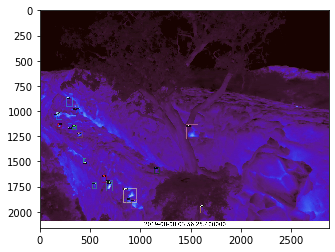

In [34]:
plt.imshow(v.get_image()[...,::-1])
v.get_image().shape

In [26]:
test = np.load(os.path.join(save_root, '{}-predictions.npy'.format(name)), allow_pickle=True)

In [50]:
files = sorted(glob.glob(os.path.join(save_root, '*-predictions.pkl')))
readfile = files[0]
with open(file, 'rb') as readfile:
    detections=pickle.load(readfile)

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(
    "/home/golden/detectron2-master/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
)



cfg.DATASETS.TRAIN = ("salmon-train",)
cfg.DATASETS.TEST = ("salmon-val",)
cfg.DATALOADER.NUM_WORKERS = 6
cfg.DATALOADER.ASPECT_RATIO_GROUPING = False

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
)
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.019
cfg.SOLVER.MAX_ITER = (2000)
cfg.SOLVER.WARMUP_ITERS = 100
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (256)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

cfg.TEST.EVAL_PERIOD = 100
cfg.TEST.DETECTIONS_PER_IMAGE = 200


cfg.INPUT.MIN_SIZE_TEST = (0)

cfg.INPUT.MAX_SIZE_TEST = (4000)



In [ ]:
# Check validation
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("salmon-val", )
predictor = DefaultPredictor(cfg)

for d in val_dicts:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_metadata,
                   scale=1.0,
                   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])